In [1]:
import glob, os, math, subprocess

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

from scipy.ndimage.morphology import binary_erosion

from nipype.interfaces.freesurfer import MRIConvert

/home/wilomaku/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/home/wilomaku/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


ModuleNotFoundError: No module named 'nipype'

In [ ]:
def mgz2nii(path_file):
    mc = MRIConvert(terminal_output='none')
    mc.inputs.in_file = '{}.mgz'.format(path_file)
    mc.inputs.out_file = '{}.nii'.format(path_file)
    mc.run()
    img_aseg = nib.load('{}.nii'.format(path_file)).get_data()
    
    os.remove('{}.nii'.format(path_file))
    
    return img_aseg

def transparent_cmap(cmap, N=255):
    "Copy colormap and set alpha values"
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-1] = np.linspace(0, 0.2, N+4)
    return mycmap

In [3]:
# Checks if a matrix is a valid rotation matrix.
def isRotationMatrix(R):
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype = R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

# Calculates rotation matrix to euler angles
# The result is the same as MATLAB except the order
# of the euler angles ( x and z are swapped ).
def rotationMatrixToEulerAngles(R):
 
    #assert(isRotationMatrix(R))
     
    sy = math.sqrt(R[0,0] * R[0,0] +  R[1,0] * R[1,0])
     
    singular = sy < 1e-6
 
    if  not singular :
        x = math.atan2(R[2,1] , R[2,2])
        y = math.atan2(-R[2,0], sy)
        z = math.atan2(R[1,0], R[0,0])
    else :
        x = math.atan2(-R[1,2], R[1,1])
        y = math.atan2(-R[2,0], sy)
        z = 0
 
    return np.array([x, y, z])

def mod_v(vect):
    return np.sqrt(np.sum(np.square(vect)))

def extract_comp(mx_affine):
    t = mx_affine[:3,-1]
    sx = mod_v(mx_affine[:3,0])
    sy = mod_v(mx_affine[:3,1])
    sz = mod_v(mx_affine[:3,2])
    #print(sx, sy, sz)
    R = np.divide(mx_affine[:3,:3], [sx, sy, sz])
    
    rx, ry, rz = rotationMatrixToEulerAngles(R)
    
    return (sx, sy, sz), (rx*180/math.pi, ry*180/math.pi, rz*180/math.pi)

def exec_rots(img, rot):
    ch_axis = np.nonzero(np.invert(np.abs(rot) >= 45))[0]
    #list_rots = np.array([[0,-1],[1,-1],[0,1]])
    list_rots = np.array([[1,-1],[0,-1],[0,1]])
    list_rots[ch_axis] = 0
    for rots in list_rots:
        img = np.swapaxes(img,rots[0],rots[1])
    return img

def createMaskSegmentationOriginal(shape, file_tag):

    shape = np.array(shape)[[1,2,0]]
    
    tag = np.loadtxt(file_tag, skiprows=4, comments=';')
    
    points = np.vstack([tag[:,:3]])

    pts_calculados  = np.zeros(tag.shape).astype('int')
    pts_calculados[:,0] = points[:,0] + (shape[2] / 2)
    pts_calculados[:,1] = points[:,1] + (shape[0] / 2)
    pts_calculados[:,2] = points[:,2] + (shape[1] / 2)

    esquerda_direita    = pts_calculados[:,0]
    anterior_posterior  = pts_calculados[:,1]
    inferior_superior   = pts_calculados[:,2]

    seg_mask = np.zeros(shape).astype('bool')
    seg_mask[anterior_posterior, inferior_superior, esquerda_direita] = True
    
    seg_mask = np.swapaxes(np.swapaxes(seg_mask, 0,2),1,2)[:,::-1]

    return seg_mask

def extract_coord(file_acpc):
    return np.rint(np.loadtxt(file_acpc, skiprows=8, comments='#')).astype('uint8')

def print_mask_img(in_img_or, mask_img, slice_sel):
    fig, ax = plt.subplots(1,3,figsize = (15,6))
    seg_bin = mask_img[slice_sel]
    seg_ero = binary_erosion(seg_bin)
    seg_brd = np.logical_xor(seg_bin,seg_ero)
    y, x = np.mgrid[0:seg_brd.shape[0], 0:seg_brd.shape[1]]

    ax[0].imshow(in_img_or[slice_sel], cmap = "gray")
    ax[0].grid(False)
    ax[1].imshow(mask_img[slice_sel], cmap = "gray")
    ax[1].grid(False)
    ax[2].imshow(in_img_or[slice_sel], cmap='gray')
    ax[2].grid(False)
    cb = ax[2].contourf(x, y, (seg_brd), 15, cmap=mycmap)
    plt.show()

In [ ]:
220.8 -> 1600

# Pipeline

############# ./dados_pipe_teste/000109/ #############
(180, 240, 240) -- (180, 240, 240)


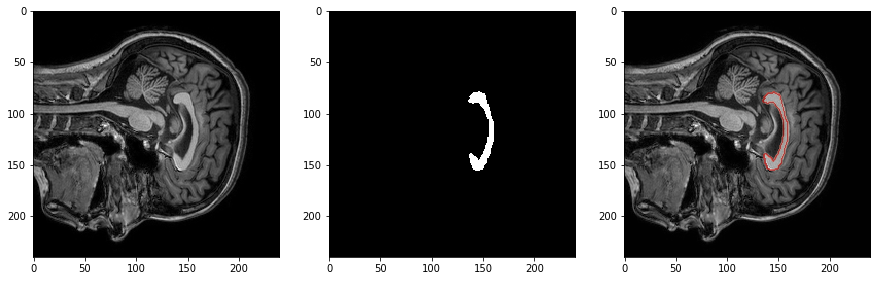

(180, 240, 240) -- (180, 240, 240)


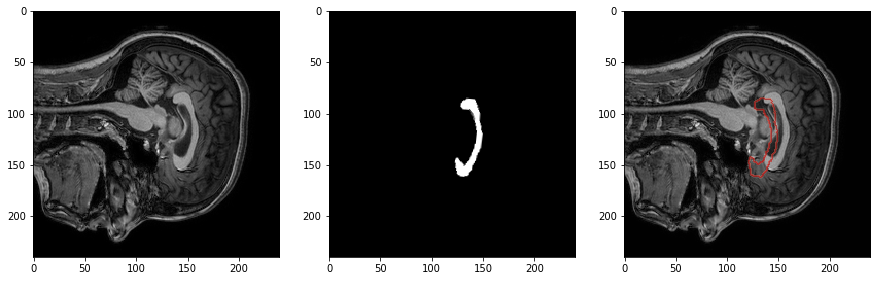

############# ./dados_pipe_teste/000110/ #############
(180, 240, 240) -- (180, 240, 240)


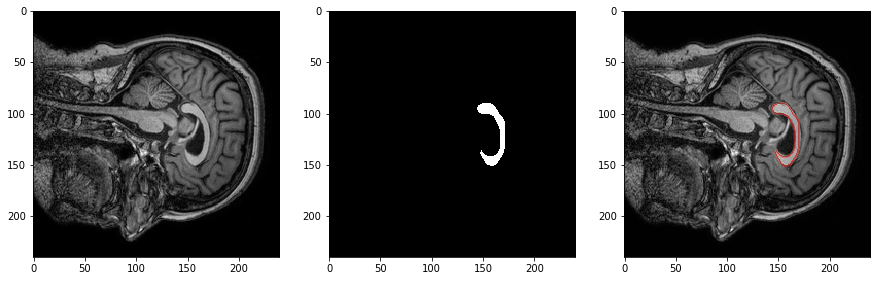

############# ./dados_pipe_teste/000111/ #############
(180, 240, 240) -- (180, 240, 240)


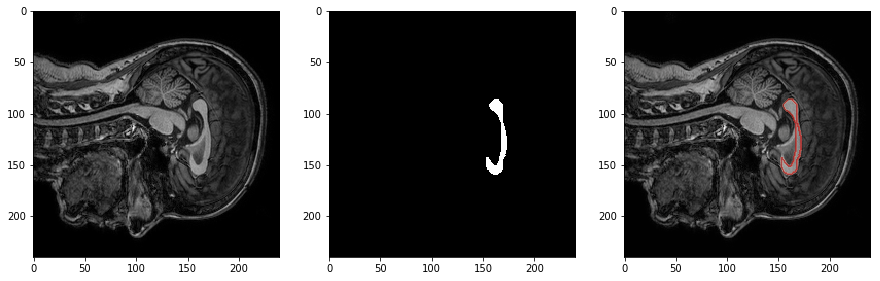

(180, 240, 240) -- (180, 240, 240)


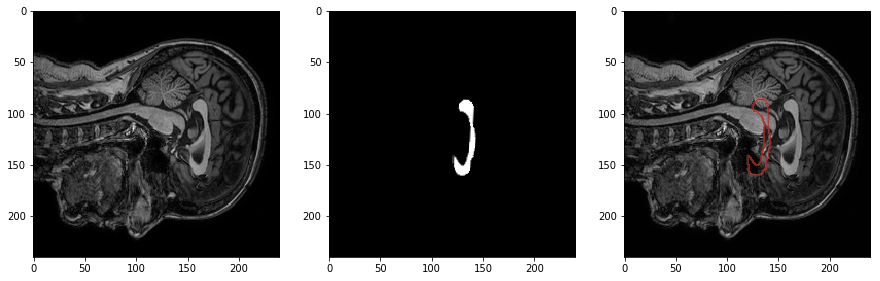

############# ./dados_pipe_teste/000112/ #############
(180, 240, 240) -- (180, 240, 240)


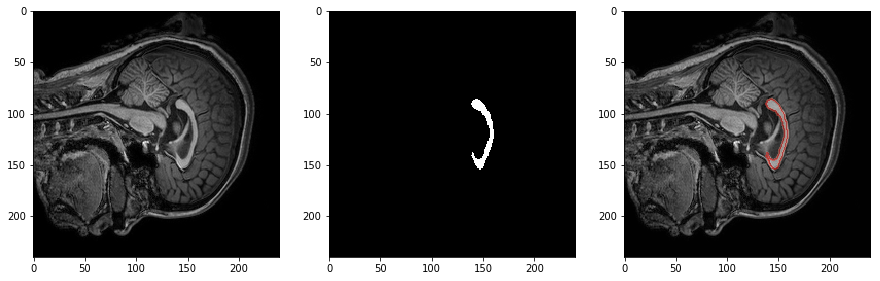

(180, 240, 240) -- (180, 240, 240)


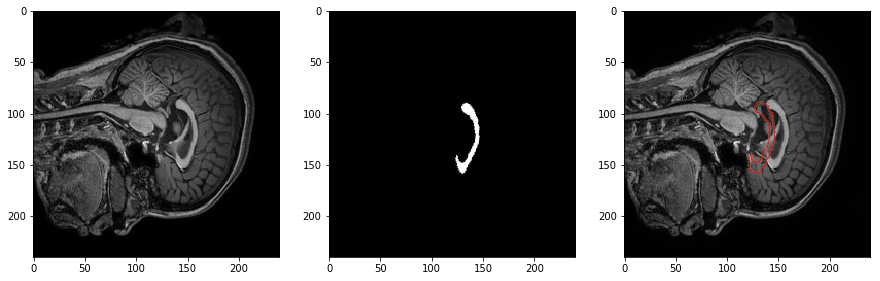

############# ./dados_pipe_teste/000113/ #############
(180, 240, 240) -- (180, 240, 240)


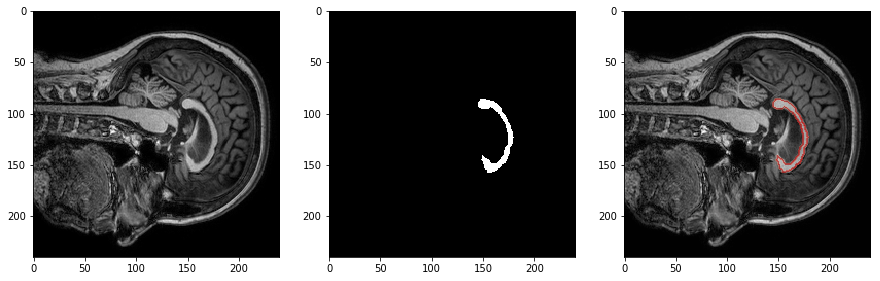

(180, 240, 240) -- (180, 240, 240)


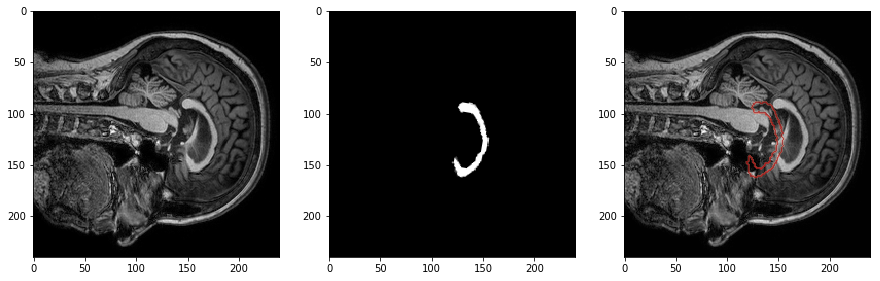

############# ./dados_pipe_teste/000114/ #############
(180, 240, 240) -- (180, 240, 240)


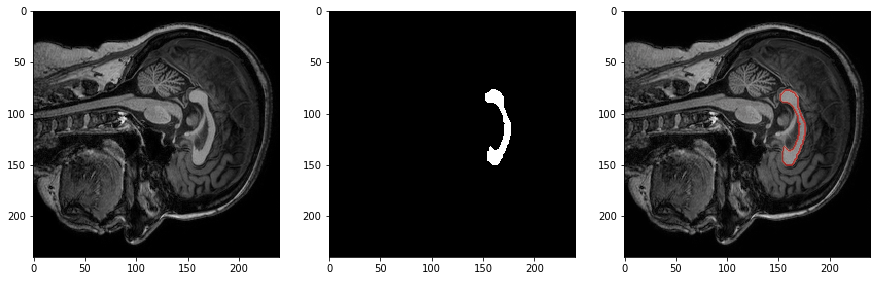

(180, 240, 240) -- (180, 240, 240)


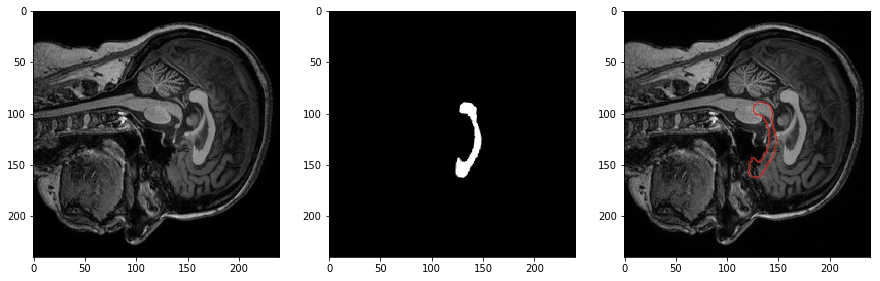

############# ./dados_pipe_teste/000115/ #############
(180, 240, 240) -- (180, 240, 240)


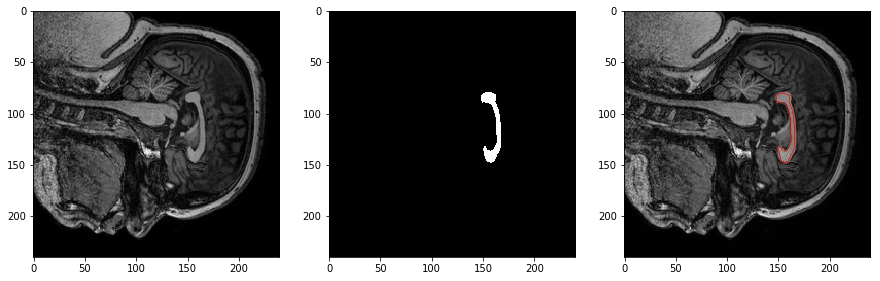

(180, 240, 240) -- (180, 240, 240)


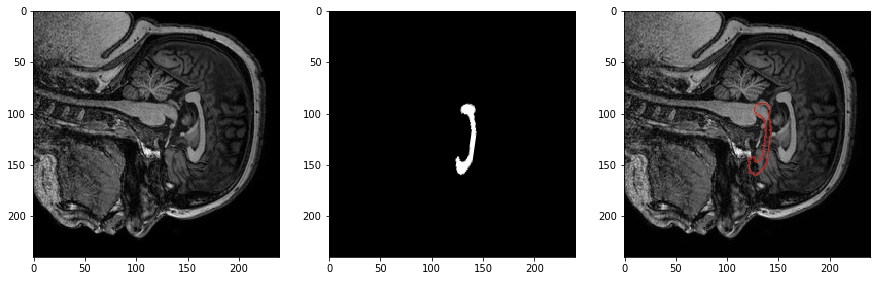

############# ./dados_pipe_teste/000116/ #############
(180, 240, 240) -- (180, 240, 240)


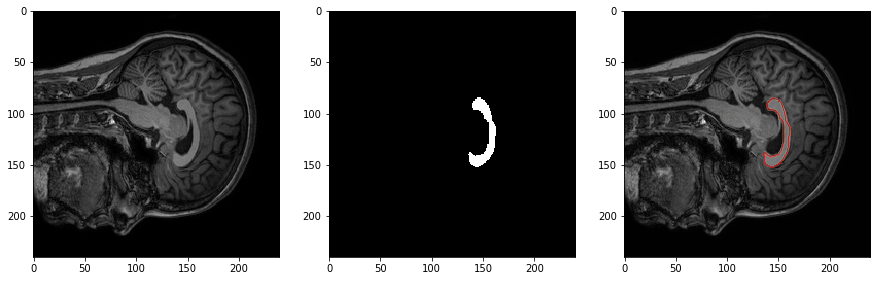

(180, 240, 240) -- (180, 240, 240)


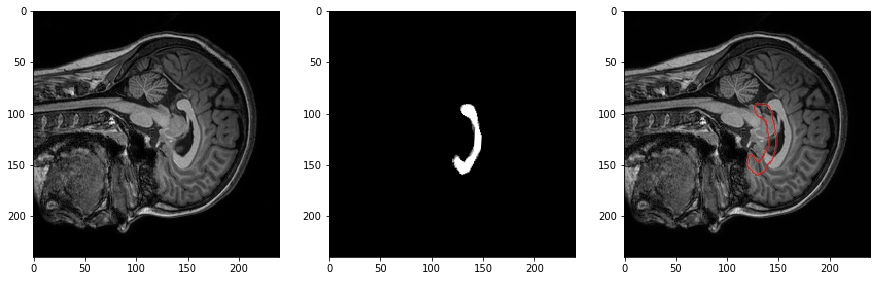

############# ./dados_pipe_teste/000117/ #############
(180, 240, 240) -- (180, 240, 240)


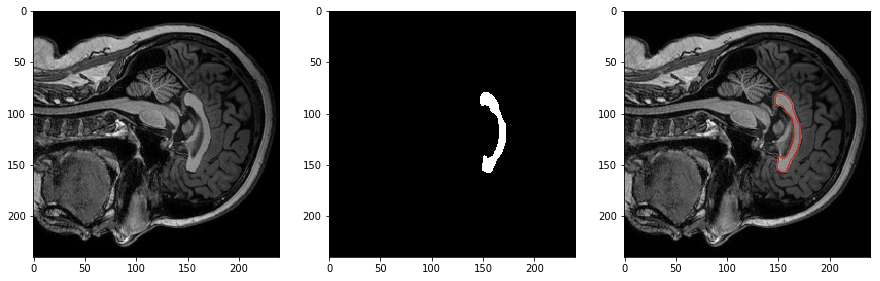

(180, 240, 240) -- (180, 240, 240)


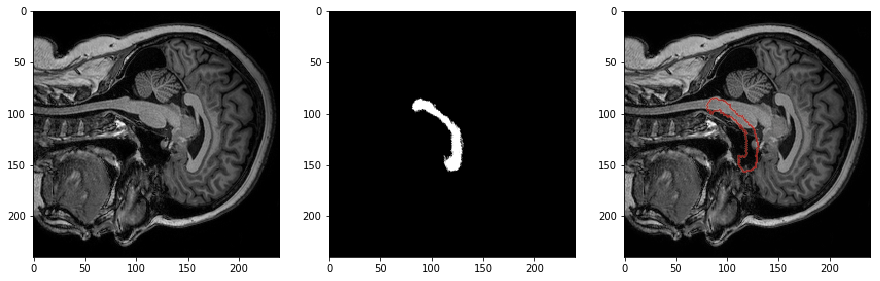

############# ./dados_pipe_teste/000118/ #############
(180, 240, 240) -- (180, 240, 240)


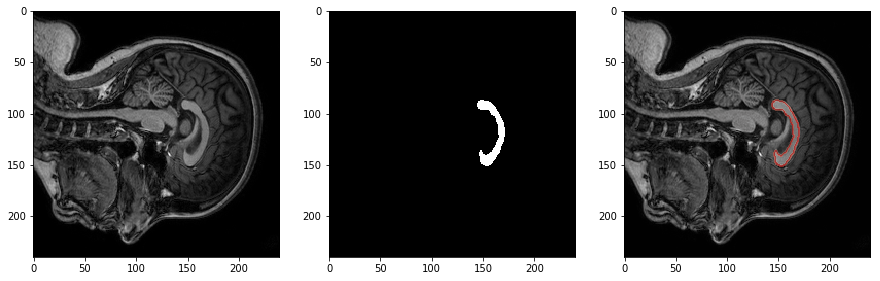

(180, 240, 240) -- (180, 240, 240)


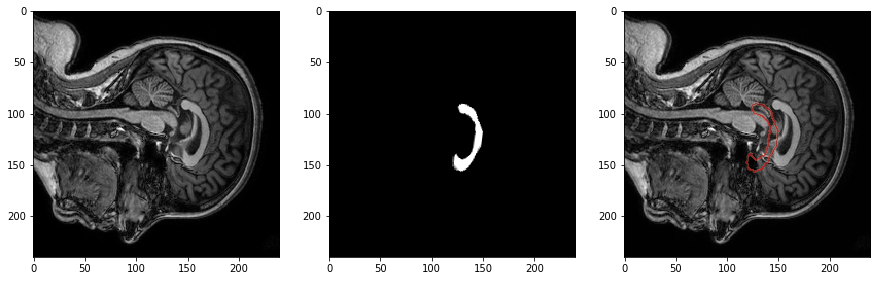

############# ./dados_pipe_teste/T1_000001/ #############
(180, 240, 240) -- (180, 240, 240)


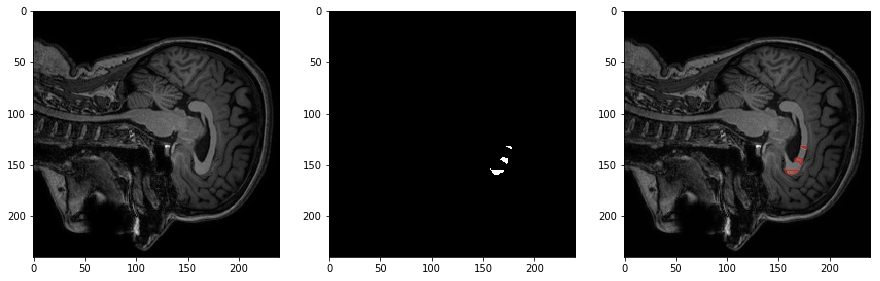

(180, 240, 240) -- (180, 240, 240)


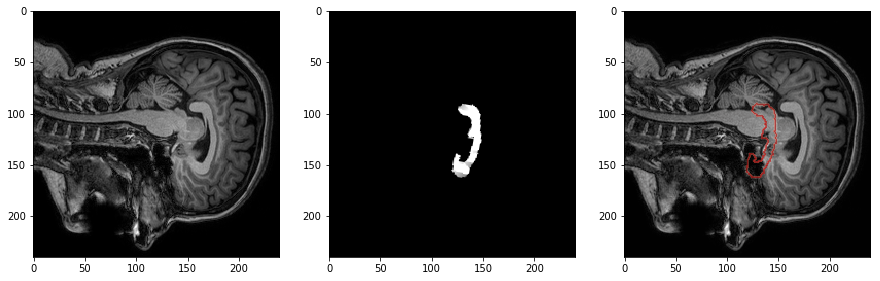

############# ./dados_pipe_teste/T1_000002/ #############
(180, 240, 240) -- (180, 240, 240)


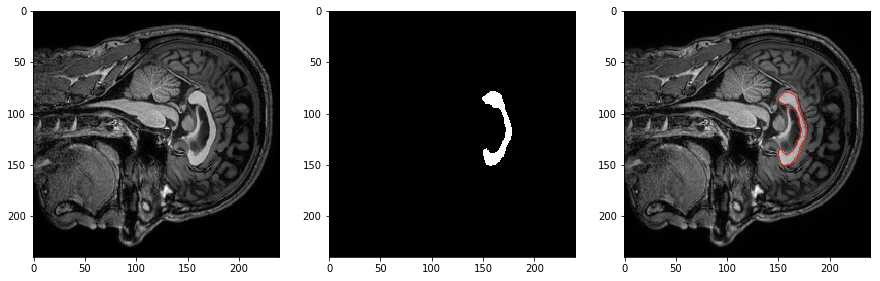

(180, 240, 240) -- (180, 240, 240)


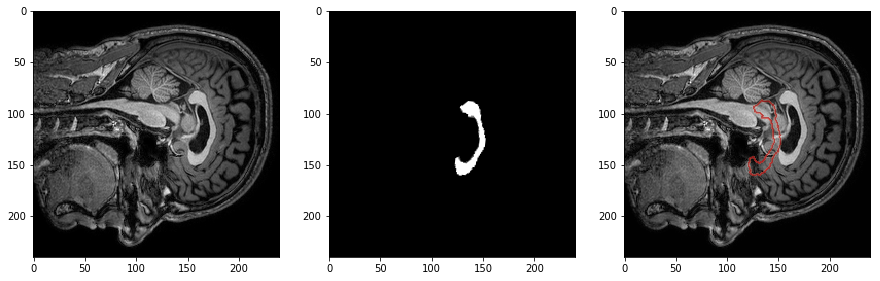

############# ./dados_pipe_teste/T1_000003/ #############
(180, 240, 240) -- (180, 240, 240)


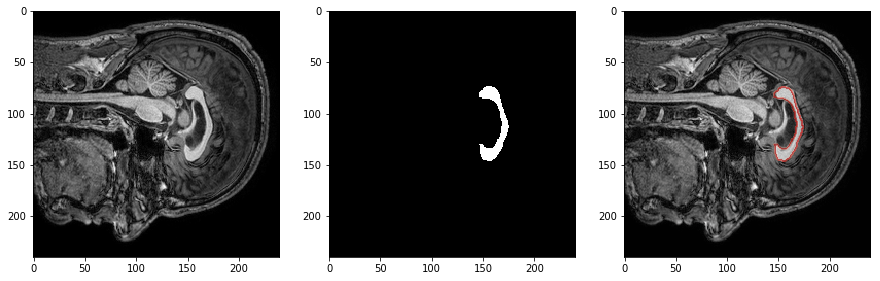

(180, 240, 240) -- (180, 240, 240)


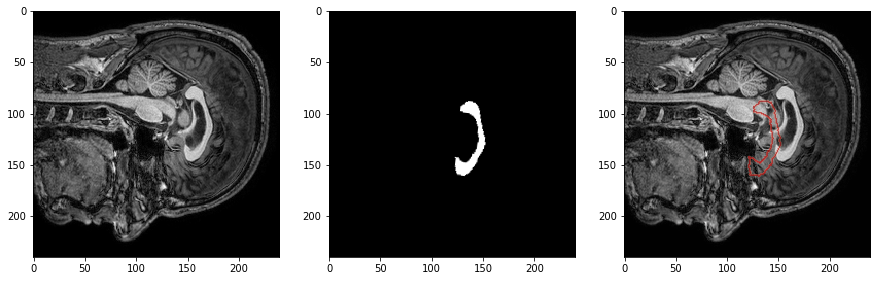

############# ./dados_pipe_teste/T1_000004/ #############
(180, 240, 240) -- (180, 240, 240)


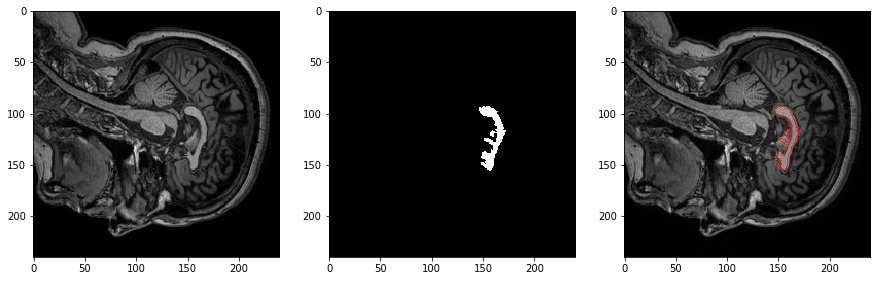

(180, 240, 240) -- (180, 240, 240)


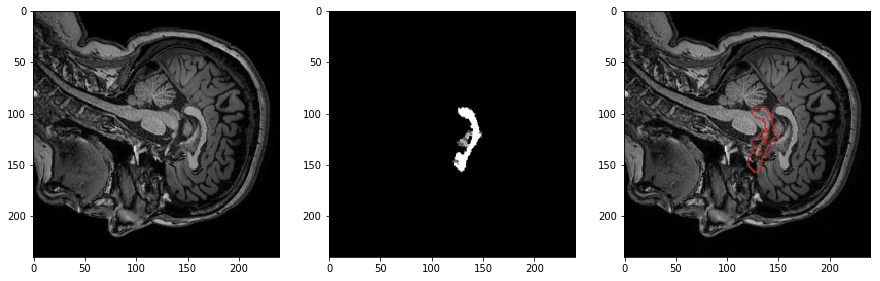

############# ./dados_pipe_teste/T1_000005/ #############
(180, 240, 240) -- (180, 240, 240)


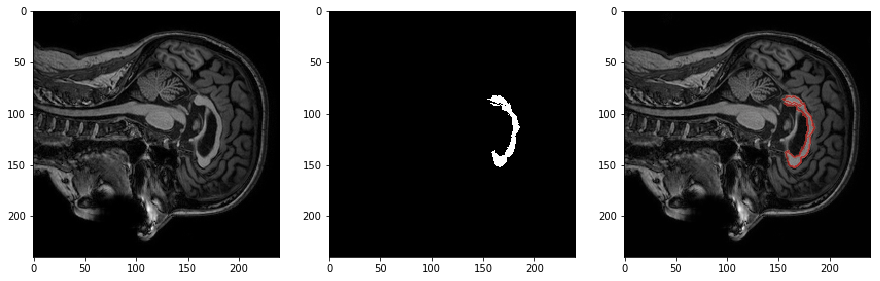

(180, 240, 240) -- (180, 240, 240)


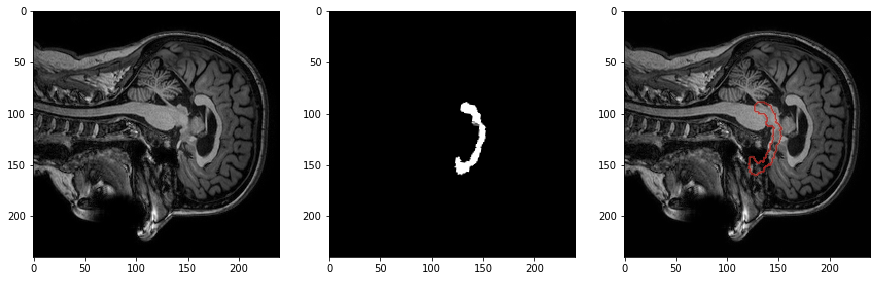

############# ./dados_pipe_teste/T1_000006/ #############
(180, 240, 240) -- (180, 240, 240)


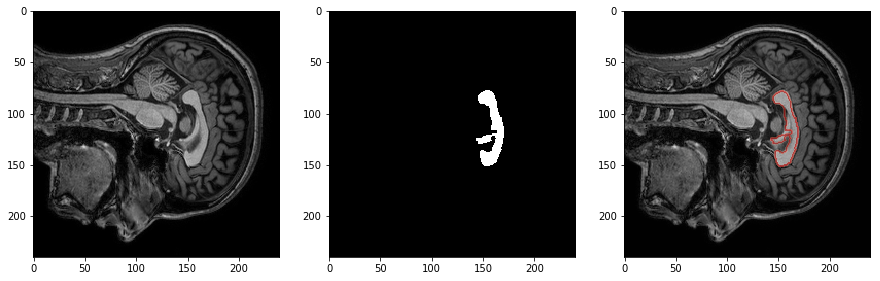

(180, 240, 240) -- (180, 240, 240)


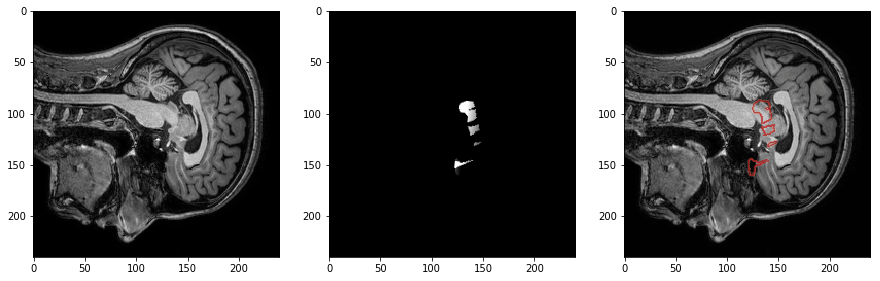

############# ./dados_pipe_teste/T1_000007/ #############
(180, 240, 240) -- (180, 240, 240)


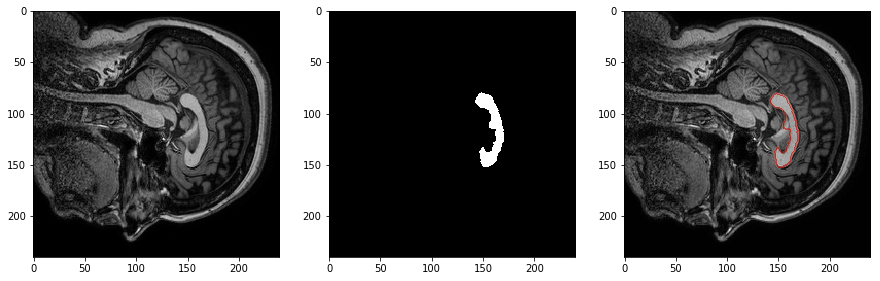

(180, 240, 240) -- (180, 240, 240)


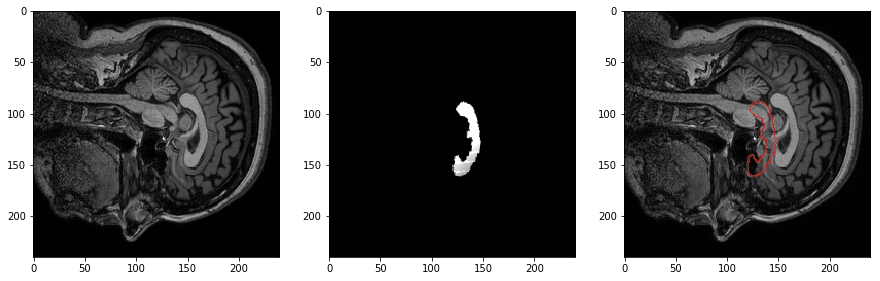

############# ./dados_pipe_teste/T1_000008/ #############
(180, 240, 240) -- (180, 240, 240)


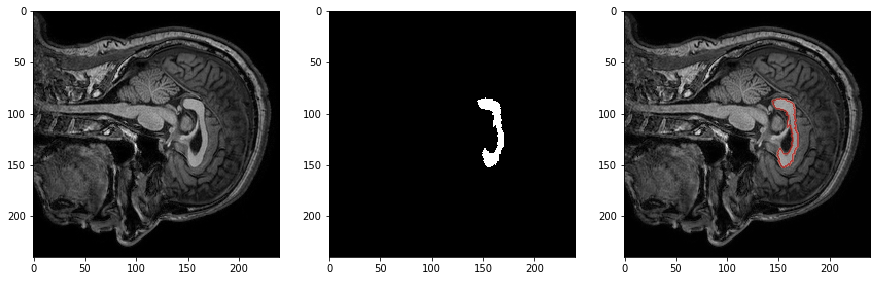

(180, 240, 240) -- (180, 240, 240)


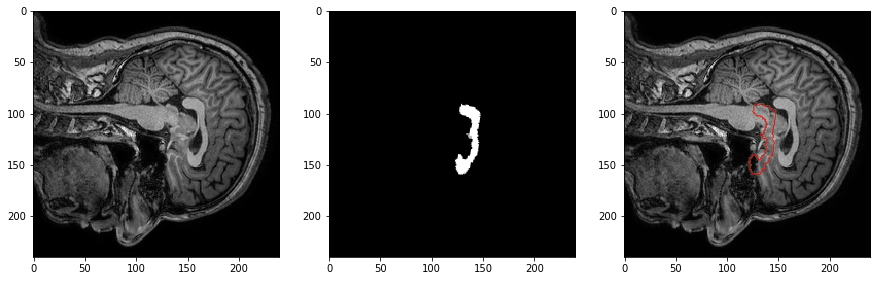

############# ./dados_pipe_teste/T1_000009/ #############
(180, 240, 240) -- (180, 240, 240)


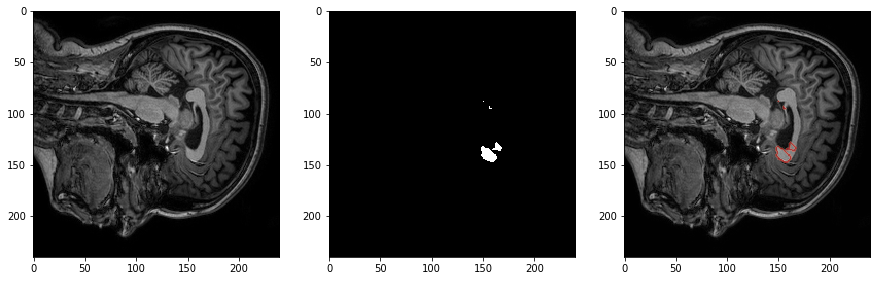

(180, 240, 240) -- (180, 240, 240)


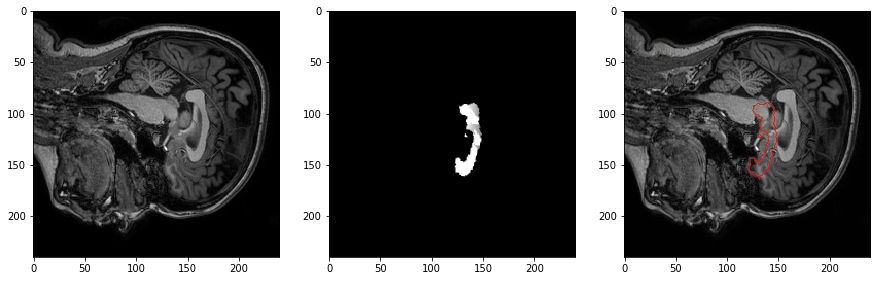

############# ./dados_pipe_teste/T1_000010/ #############
(180, 240, 240) -- (180, 240, 240)


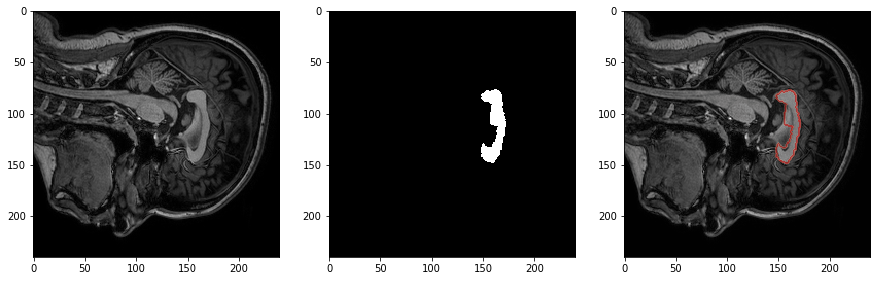

(180, 240, 240) -- (180, 240, 240)


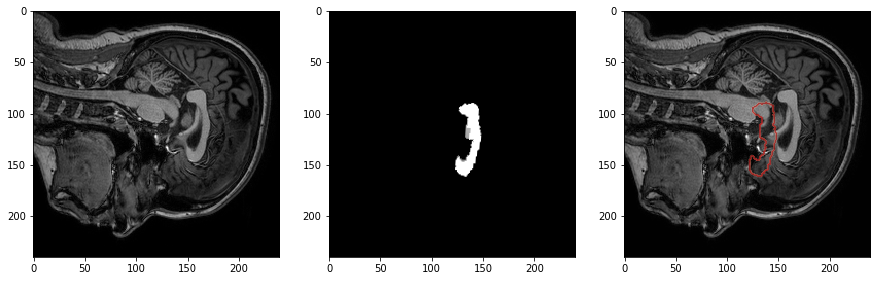

['./dados_pipe_teste/000110/']


In [4]:
list_dirs = glob.glob('./dados_pipe_teste/*')

logfile_path = '{}log.txt'.format('./')
log = open(logfile_path, 'wb')

flirt_cmd = 'flirt.fsl'
errs = []
mycmap = transparent_cmap(plt.cm.Reds)

for dir_ in list_dirs:
    dir_ = dir_+'/'
    try:
        print('############# {} #############'.format(dir_))
        file_t1 = glob.glob('{}T1_*.nii*'.format(dir_))
        file_t1.sort(key=len, reverse=False)
        fl_gz = 0
        
        if file_t1 != []:
            file_t1 = file_t1[0]
            if file_t1[-3:] == '.gz':
                subprocess.call(['gunzip', '-k', '{}'.format(file_t1)], stderr = log, stdout = log)
                fl_gz = 1
                file_t1 = file_t1[:-3]
        else:
            print("File T1 doesn't exist")

        prefix = file_t1.split('/')[-1].split('.')[0]+'_'

        #Defining paths -input
        file_transform = '{}{}FSL.mat'.format(dir_,prefix)
        #file_t1 = '{}t1.nii'.format(dir_)
        file_tag = glob.glob('{}*.tag'.format(dir_))
        #Defining paths -outputs
        file_mask = '{}mask.nii'.format(dir_)
        file_ref = '{}ref.nii'.format(dir_)
        file_msp_points = '{}msp_points.nii'.format(dir_)
        file_acpc = '{}{}ACPC.txt'.format(dir_,prefix)
        #Defining paths -outputs
        file_t1_reg = '{}t1_reg'.format(dir_)
        file_mask_reg = '{}mask_reg'.format(dir_)
        msp_points_reg = '{}msp_points_reg'.format(dir_)

        #Run acpcdetect
        subprocess.call(['acpcdetect','-i', file_t1, '-v'], stderr = log, stdout = log)

        #Loading transform matrix in FSL format
        mx_trans = np.loadtxt(file_transform)

        #Creating and saving manual mask from txt
        img_t1 = nib.load(file_t1)

        if file_tag != []:
            file_tag = file_tag[0]
            mask_img = createMaskSegmentationOriginal(img_t1.get_data().shape, file_tag).astype('uint8')
            mask_img_nii = nib.Nifti1Image(mask_img, affine=img_t1.affine)
            nib.save(mask_img_nii, file_mask)
        else:
            if os.path.exists('{}aseg.mgz'.format(dir_)):
                subprocess.call(['mri_label2vol','--seg', '{}aseg.mgz'.format(dir_), 
                                 '--temp', '{}rawavg.mgz'.format(dir_),
                                 '--o', '{}aseg-in-rawavg.mgz'.format(dir_),
                                 '--regheader', '{}aseg.mgz'.format(dir_)], stderr = log, stdout = log)
                data_aseg = mgz2nii('{}aseg-in-rawavg'.format(dir_))
                mask_img = np.zeros_like(data_aseg)
                for label in np.arange(251,256):
                    mask_img[data_aseg == label] = 1
                mask_img_nii = nib.Nifti1Image(mask_img, affine=img_t1.affine)
                nib.save(mask_img_nii, file_mask)
                #subprocess.call(['rm', '{}mri/aseg-in-rawavg.mgz'.format(dir_)], stderr = log, stdout = log)
            else:
                print("Mask doesn't exist")    

        #### Plotting original images
        in_img_or = nib.load('{}'.format(file_t1)).get_data()
        print(in_img_or.shape, '--', mask_img.shape)
        print_mask_img(in_img_or, mask_img, slice_sel=in_img_or.shape[0]//2)

        #Creating and saving reference image
        stretch, rot = extract_comp(mx_trans)
        ref_img = exec_rots(img_t1.get_data(), rot)
        ref_img_nii = nib.Nifti1Image(ref_img, affine = img_t1.affine, header = img_t1.header)
        nib.save(ref_img_nii, file_ref)

        #Creating 3D grid with apcp points
        msp_points = img_t1.get_data()
        msp_points[:,:,:] = 0
        for row in extract_coord(file_acpc):
            msp_points[row[0],row[1],row[2]] = 1
        msp_points_nii = nib.Nifti1Image(msp_points, affine = img_t1.affine, header = img_t1.header)
        nib.save(msp_points_nii, file_msp_points)

        #Registering using reference image and transformation matrix
        subprocess.call([flirt_cmd,'-in', file_t1, '-ref', file_ref, '-out', file_t1_reg, '-init', file_transform,
                                         '-applyxfm'], stderr = log, stdout = log)
        subprocess.call([flirt_cmd,'-in', file_mask, '-ref', file_ref, '-out', file_mask_reg, '-init', file_transform,
                                         '-applyxfm'], stderr = log, stdout = log)
        subprocess.call([flirt_cmd,'-in', file_msp_points, '-ref', file_ref, '-out', msp_points_reg, '-init', file_transform,
                                         '-applyxfm'], stderr = log, stdout = log)

        #Finding MSP after registered points
        in_img_msp = nib.load('{}.nii.gz'.format(msp_points_reg)).get_data()
        msp = np.argmax(np.sum(np.sum(in_img_msp,axis=-1),axis=-1))

        #### Plotting MSP images
        in_img = nib.load('{}.nii.gz'.format(file_t1_reg)).get_data()
        in_img_mask = nib.load('{}.nii.gz'.format(file_mask_reg)).get_data()
        print(in_img.shape, '--', in_img_mask.shape)
        print_mask_img(in_img_or, in_img_mask, slice_sel=msp)

        #Removing extra files
        subprocess.call(['rm', file_ref, file_msp_points], stderr = log, stdout = log)
        #subprocess.call(['rm', '{}ACPC_axial.ppm'.format(prefix), '{}ACPC_sagittal.ppm'.format(prefix),
        #                 '{}orion.ppm'.format(prefix), '{}orion.txt'.format(prefix)], stderr = log, stdout = log)
        if fl_gz == 1:
            subprocess.call(['rm', file_t1], stderr = log, stdout = log)
    except:
        errs.append(dir_)
print(errs)
log.close()